## The Steady State Equation
-----------

\\[
\nabla \cdot q = h
\\]

\\[
q = - k \nabla T
\\]

where:
 * $T$ is a scalar quantity 
 * $k$ is diffusion (or conductivity) coefficient
 * $q$ is the heat flux vector 
 * $h$ is the source/sink term

-----

Here we consider 2D models in the region, $0 \leqslant x \leqslant 1 $ and $ y_{0}\leqslant y \leqslant y_{1}$

with no variation in the x direction, i.e. $ \frac{\partial T}{\partial x} = 0 $ and a constant value $ k $ across the domain. 

Leading the 1D general solution:

$ T = -\frac{h}{2 k}y^{2} + c_{0}y + c_{1} $

where $c_{0}, c_{1}$ are arbitrary constants found by applying each model's boundary conditions

Three models are presented below, each with an analytic solution that the numerical results are tested against.

In [1]:
# analytic solution definitions
def analyticTemperature(y, h, k, c0, c1):
     return -h/(2.*k)*y**2 + c0*y + c1

def exactDeriv(y, h, k, c0):
    return -h/k*y + c0

In [2]:
import underworld as uw
import underworld.visualisation as vis
import numpy as np
uw.utils.matplotlib_inline()
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
pyplot.ion() # needed to ensure pure python jobs do now hang on show()

rank = uw.mpi.rank

# for machines without matplotlib #
make_graphs = False
if uw.utils.is_kernel(): 
    make_graphs = True
    try:
        import matplotlib
    except ImportError:
        make_graphs=False

# depth range
y0 = -.60
y1 = 1.3

# build mesh and fields
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (10, 20), 
                                 minCoord    = (0., y0), 
                                 maxCoord    = (1., y1))

tField    = mesh.add_variable( nodeDofCount=1, dataType='double')
topWall    = mesh.specialSets['MaxJ_VertexSet']
bottomWall = mesh.specialSets['MinJ_VertexSet']

## Model 1)

 * a fixed temperature condition or `DirichletCondition` - topWall 
 
 $ T(x,y_{1}) = T_{1} $

 * a heat flow condition or `NeumannCondition` - bottomWall.

 $ q \cdot n_{b} = (\,0.0\,,\, f\,) \cdot (\,0.0\,,\,-1.0\,) = - f$
 
     **Note** The heat flow is calculated using the heat flux vector $q$ multiplied by the outward surface normal, $n$. 
     The bottom surface outward normal $n_{b}$ point along the negative j-axis 


When the `NeumannCondition` object is associated with the `SteadyStateHeat` system it defines a flux along a boundary such that:
   
$ q \cdot n = \phi $ at $ \Gamma_{\phi} $

where:
* $ \Gamma_{\phi} $ is the set of vertices along the surface of the domain, 
* $\phi $ is the scalar flow associated with the vector flux $q$ along $\Gamma_{\phi}$


---------------

An example: Defining a scalar field's flux at the bottom wall in a 2D rectangular domain.

The outward facing normal vector at the bottom wall $\mathbf{n}\mid_{(x,y_{0})}=\left[0,-1\right] $) and the imposed flux vector $k \nabla T = \left[0, \phi\right]$

The `NeumannCondition` object definition of this condition would be: 

```
nbc = uw.conditions.NeumannCondition( fn_flux= -1.0 * phi, variable=tField,
                                      indexSetsPerDof=mesh.specialSets["MinJ_VertexSet"] )
```

Applies a 'fn_flux' to the scalar 'variable' `MeshVariable` over the boundary vertices in the set 'indexSetsPerDof'. The factor -1 is from the vector multiplication with the outward facing normal vector.

Here `phi` can be a `underworld.Function` or `underworld.MeshVariable` type.

------

Arbitrary constants are:

$c_{0} = \frac{1}{k} (\,f + hy_{0}\,) $

$c_{1} = T_{1} + \frac{h}{2 k}y_{1}^2 - c_{0}y_{1} $


In [3]:
T1 = 8.0       # surface temperature
k = 6.7        # diffusivity
h = 8.0        # heat production, source term
f = 2. 

# analytic solution definitions
# 1 dirichlet conditions (top) + 1 neumann (bottom)
c0 = 1./k*(f+h*y0)
c1 = T1 + h/(2.0*k)*y1**2 - c0*y1

In [4]:
for ii in topWall:
    tField.data[ii] = T1

# flag the dirichlet conditions on the topWall only
bc = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(topWall) )

# define neumann condition
nbc = uw.conditions.NeumannCondition( variable=tField,
                                      fn_flux=-f,
                                      indexSetsPerDof=(bottomWall))

# flag the dirichlet conditions on the topWall only
bc = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(topWall) )

# define heat eq. system
ss = uw.systems.SteadyStateHeat( temperatureField  = tField,
                                 fn_diffusivity = k,
                                 fn_heating     = h,
                                 conditions     = [bc, nbc] ) 

In [5]:
solver = uw.systems.Solver(ss)
solver.solve()

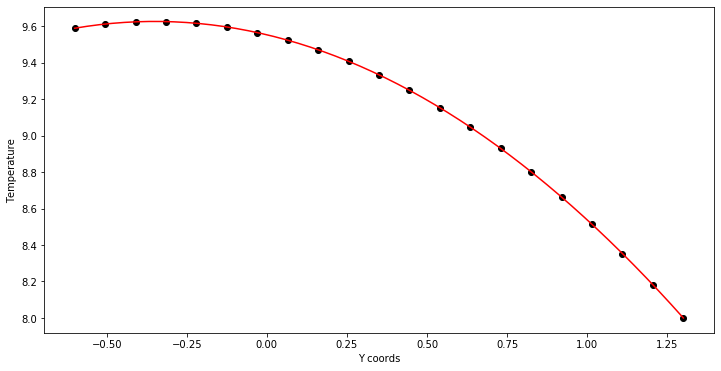

Numerical flux at y =  -0.6 is 0.241786540078
Exact     flux at y =  -0.6 is 0.2985074626865672

Abs. error = 2.581e-04
Rel. error = 6.156e-06


In [8]:
# create numpy arrays for analytics, parallel check first

yvals       = np.zeros(len(mesh.specialSets['MinI_VertexSet']))
ycoord      = np.zeros_like(yvals)
analytic    = np.zeros_like(yvals)

ids = mesh.specialSets['MinI_VertexSet']
yvals[:] = tField.evaluate(ids).T

ycoord = tField.mesh.data[ids.data,[1]]
analytic = analyticTemperature(ycoord, h, k, c0, c1)

# measure border flux, analytic is easy, parallel check needed for numeric result
yspot = y0
ana_flux = exactDeriv(yspot,h,k,c0)

tmp = tField.fn_gradient.evaluate_global([0.2,yspot])
if tmp is not None: num_flux = tmp[0][1]
else: num_flux = 0.


from mpi4py import MPI
comm = MPI.COMM_WORLD
# assuming order in the allgather is the same
coords = comm.allgather(ycoord)
numerical = comm.allgather(yvals)

if make_graphs:

    # 1st build exact solution hiRes
    big = np.linspace(y0,y1)
    cool = analyticTemperature(big, h, k, c0, c1)

    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.plot(coords, numerical, 'o', color = 'black', label='numerical') 
    pyplot.plot(big, cool, color = 'red', label="exact") 
    pyplot.xlabel('Y coords')
    pyplot.ylabel('Temperature')
    pyplot.show()


if rank == 0:
    threshold = 1.0e-4
    yspot = y0
    abserr = np.linalg.norm(analytic - yvals)
    mag = np.linalg.norm(analytic)
    relerr = abserr / mag
    print("Numerical flux at y = " ,yspot,"is", num_flux)
    print("Exact     flux at y = " ,yspot,"is", ana_flux)
    print("\nAbs. error = {0:.3e}".format(abserr))
    print("Rel. error = {0:.3e}".format(relerr))
    if relerr > threshold:
        raise RuntimeError("The numerical solution is outside the error threshold of the analytic solution." \
                           "The Relative error was ", relerr," the threshold is ", threshold)

## Model 2)

 * a fixed temperature condition or Dirichlet BC - bottomWall 
 
 $ T(x,y_{0}) = T_{0} $

 * a heat flow condition or Neumann BC - topWall.

 $ q \cdot n_{u} = (\,0.0\,,\, f\,) \cdot (\,0.0\,,\,1.0\,) = f$
 
     **Note** The top surface outward normal $n_{u}$ point along the j-axis 

------

Arbitrary constants are:

$c_{0} = \frac{1}{k} (\,f + hy_{1}\,) $

$c_{1} = T_{0} + \frac{h}{2 k}y_{0}^2 - c_{0}y_{0} $

In [25]:
T0 = 8.0       # surface temperature
k = 2.2        # diffusivity
h = -7.4       # heat production, source term
f = 4.0        # temperature flow, implies negative gradient

# analytic solution definitions
# 1 dirichlet conditions (top) + 1 neumann (bottom)
c0 = 1.0*(f+h*y1)/k
c1 = T0 + h/(2.0*k)*y0**2 - c0*y0

In [26]:
for ii in bottomWall:
    tField.data[ii] = T0

# define neumann condition
nbc = uw.conditions.NeumannCondition( fn_flux=f, 
                                      variable=tField, 
                                      indexSetsPerDof=(topWall) )

# flag the dirichlet conditions on the topWall only
bc = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(bottomWall) )


# define heat eq. system
ss = uw.systems.SteadyStateHeat( temperatureField  = tField,
                                 fn_diffusivity = k,
                                 fn_heating     = h,
                                 conditions     = [bc, nbc] ) 

In [27]:
solver = uw.systems.Solver(ss)
solver.solve()

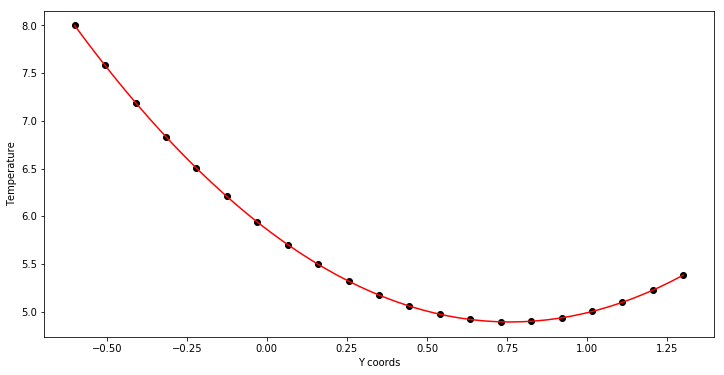

Numerical flux at y =  1.3 is -4.41274249682
Exact     flux at y =  1.3 is -4.57272727273

Abs. error = 1.252e-03
Rel. error = 4.705e-05


In [28]:
# create numpy arrays for analytics
yvals       = np.zeros(len(mesh.specialSets['MinI_VertexSet']))
ycoord      = np.zeros_like(yvals)
analytic    = np.zeros_like(yvals)

ids = mesh.specialSets['MinI_VertexSet']
yvals[:] = tField.evaluate(ids).T

ycoord = tField.mesh.data[ids.data,[1]]
analytic = analyticTemperature(ycoord, h, k, c0, c1)

'''
abserr = uw.utils._nps_2norm(analytic - yvals)
mag = uw.utils._nps_2norm(analytic)
relerr = abserr / mag
'''

# measure border flux, analytic is easy, parallel check needed for numeric result
yspot = y0
ana_flux = exactDeriv(yspot,h,k,c0)

tmp = tField.fn_gradient.evaluate_global([0.2,yspot])
if tmp is not None: num_flux = tmp[0][1]
else: num_flux = 0.

from mpi4py import MPI
comm = MPI.COMM_WORLD
# assuming order in the allgather is the same
coords = comm.allgather(ycoord)
numerical = comm.allgather(yvals)

if make_graphs:

    # 1st build exact solution hiRes
    big = np.linspace(y0,y1)
    cool = analyticTemperature(big, h, k, c0, c1)

    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.plot(coords, numerical, 'o', color = 'black', label='numerical') 
    pyplot.plot(big, cool, color = 'red', label="exact") 
    pyplot.xlabel('Y coords')
    pyplot.ylabel('Temperature')
    pyplot.show()


if rank == 0:
    threshold = 1.0e-4
    yspot = y1
    abserr = np.linalg.norm(analytic - yvals)
    mag = np.linalg.norm(analytic)
    relerr = abserr / mag
    print("Numerical flux at y = " ,yspot,"is", num_flux)
    print("Exact     flux at y = " ,yspot,"is", ana_flux)
    print("\nAbs. error = {0:.3e}".format(abserr))
    print("Rel. error = {0:.3e}".format(relerr))
    if relerr > threshold:
        raise RuntimeError("The numerical solution is outside the error threshold of the analytic solution." \
                           "The Relative error was ", relerr," the threshold is ", threshold)

## Model 3) 

2D, Steady State Heat Equation with Dirichlet BC at the top and bottom surfaces.

$T(x,y_{1}) = T_{1}$

$ T(x,y_{0}) = T_{0} $

------

arbitrary constants are:

$ c_{0} = \frac{1}{y_{1}-y_{0}} \left[ T_{1}-T_{0}+\frac{h} {2k}(y_{1}^2-y_{0}^2) \right] $

$c_{1} = T_{1} + \frac{h}{2k}y_{1}^2 - c_{0}y_{1}$


In [15]:
# Model parameters
T1 = 8.0   # top surface temperature
T0 = 4.0   # bottom surface temperature
k = 0.50   # diffusivity
h = 10     # heat production, source term

# arbitrary constant given the 2 dirichlet conditions
c0 = (T1-T0+h/(2*k)*(y1**2-y0**2)) / (y1-y0)
c1 = T1 + h/(2*k)*y1**2 - c0*y1

In [16]:
# set boundary conditions
for ii in topWall:
    tField.data[ii] = T1
for ii in bottomWall:
    tField.data[ii] = T0

# flag boundary conditions
bc = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(topWall+bottomWall) )

# define heat eq. system
ss = uw.systems.SteadyStateHeat( temperatureField  = tField,
                                 fn_diffusivity = k,
                                 fn_heating     = h,
                                 conditions     = [bc] )

In [17]:
solver = uw.systems.Solver(ss)
solver.solve()

In [18]:
# create numpy arrays for analytics
yvals       = np.zeros(len(mesh.specialSets['MinI_VertexSet']))
ycoord      = np.zeros_like(yvals)
analytic    = np.zeros_like(yvals)

ids = mesh.specialSets['MinI_VertexSet']
yvals[:] = tField.evaluate(ids).T

ycoord   = tField.mesh.data[ids.data,[1]]
analytic = analyticTemperature(ycoord, h, k, c0, c1)

'''
abserr = uw.utils._nps_2norm(analytic - yvals)
mag = uw.utils._nps_2norm(analytic)
relerr = abserr / mag
'''
# measure border flux, analytic is easy, parallel check needed for numeric result
yspot = y0
ana_flux = exactDeriv(yspot,h,k,c0)

tmp = tField.fn_gradient.evaluate_global([0.2,yspot])
if tmp is not None: num_flux = tmp[0][1]
else: num_flux = 0.

from mpi4py import MPI
comm = MPI.COMM_WORLD
# assuming order in the allgather is the same
coords = comm.allgather(ycoord)
numerical = comm.allgather(yvals)

In [19]:
if rank == 0:
    threshold = 1.0e-4
    yspot = y0
    abserr = np.linalg.norm(analytic - yvals)
    mag = np.linalg.norm(analytic)
    relerr = abserr / mag
    print("Numerical flux at y = " ,yspot,"is", num_flux)
    print("Exact flux at y=" ,yspot,"is", ana_flux)
    print("\nAbs. error = {0:.3e}".format(abserr))
    print("Rel. error = {0:.3e}".format(relerr))
    if relerr > threshold:
        raise RuntimeError("The numerical solution is outside the error threshold of the analytic solution." \
                           "The Relative error was ", relerr," the threshold is ", threshold)  
        

Numerical flux at y =  -0.6 is 20.1552435024
Exact flux at y= -0.6 is 21.10526315789474

Abs. error = 1.988e-04
Rel. error = 3.573e-06


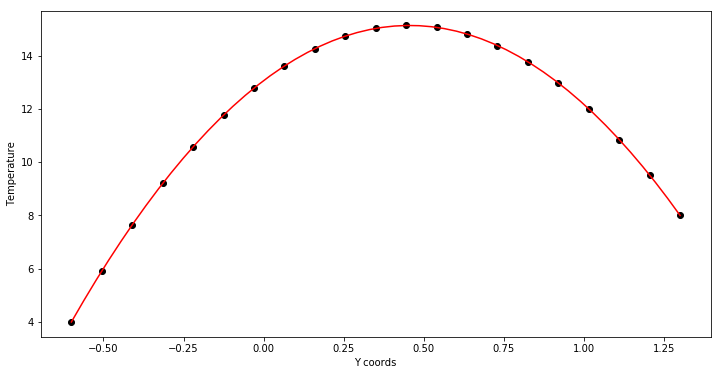

In [20]:

if make_graphs:

    # 1st build exact solution hiRes
    big = np.linspace(y0,y1)
    cool = analyticTemperature(big, h, k, c0, c1)

    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.plot(coords, numerical, 'o', color = 'black', label='numerical') 
    pyplot.plot(big, cool, color = 'red', label="exact") 
    pyplot.xlabel('Y coords')
    pyplot.ylabel('Temperature')
    pyplot.show()
